In [1]:
import rasterio as rio
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import geopandas as gpd
import shapely.geometry
import shapely.ops
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES
from pyts.decomposition import SingularSpectrumAnalysis

import warnings
warnings.filterwarnings('ignore')

dataDirDiscovery = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate'

In [2]:
run ../util/setupConsole

In [3]:
# low and high temps for gdd/kdd calcs, taken from Butler, et al, 2015, ERL
t_low = 9
t_high = 29

crop = 'Maize'
wxData = 'era5'

useTrendMethod = True
useDeepak = False

yearRange = [1981, 2019]

In [4]:
sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)

In [5]:
# # load gdd/kdd from cpc temperature data
# if wxData == 'gldas':
#     gdd = np.full([len(sacksLat), len(sacksLon), (yearRange[1]-yearRange[0]+1)], np.nan)
#     kdd = np.full([len(sacksLat), len(sacksLon), (yearRange[1]-yearRange[0]+1)], np.nan)
    
#     for y, year in enumerate(np.arange(yearRange[0], yearRange[1]+1)):
#         with gzip.open('%s/kdd-cpc-%s-%d.dat'%(dataDirDiscovery, crop, year), 'rb') as f:
#             curKdd = pickle.load(f)
#             kdd[:, :, y] = curKdd

#         with gzip.open('%s/gdd-cpc-%s-%d.dat'%(dataDirDiscovery, crop, year), 'rb') as f:
#             curGdd = pickle.load(f)
#             gdd[:, :, y] = curGdd
    
#     with gzip.open('%s/gdd-kdd-lat-cpc.dat'%(dataDirDiscovery), 'rb') as f:
#         lat = pickle.load(f)

#     with gzip.open('%s/gdd-kdd-lon-cpc.dat'%(dataDirDiscovery), 'rb') as f:
#         lon = pickle.load(f)
        
# elif wxData == 'era5':
#     gdd = np.full([721, 1440, (yearRange[1]-yearRange[0]+1)], np.nan)
#     kdd = np.full([721, 1440, (yearRange[1]-yearRange[0]+1)], np.nan)

#     for y, year in enumerate(np.arange(yearRange[0], yearRange[1]+1)):
#         with gzip.open('%s/kdd-%s-%s-%d.dat'%(dataDirDiscovery, wxData, crop, year), 'rb') as f:
#             curKdd = pickle.load(f)
#             kdd[:, :, y] = curKdd

#         with gzip.open('%s/gdd-%s-%s-%d.dat'%(dataDirDiscovery, wxData, crop, year), 'rb') as f:
#             curGdd = pickle.load(f)
#             gdd[:, :, y] = curGdd

#     with gzip.open('%s/gdd-kdd-lat-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
#         lat = pickle.load(f)

#     with gzip.open('%s/gdd-kdd-lon-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
#         lon = pickle.load(f)


In [6]:
usStateAbbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [7]:
minCropYears = 10
minCropYearsDeepak = 10

rebuild=False

if os.path.isfile('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData)) and not rebuild:
    usCounties = pd.read_pickle('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData))


In [8]:
usCounties = usCounties.drop(columns=['CWA', 'TIME_ZONE', 'FE_AREA'])

In [9]:
# drop all counties with any nans
yieldNans = np.array(list(map(np.isnan, usCounties['maizeYield'])))
yieldTrendNans = np.array(list(map(np.isnan, usCounties['maizeYieldTrend'])))
gddNans = np.array(list(map(np.isnan, usCounties['gdd'])))
kddNans = np.array(list(map(np.isnan, usCounties['kdd'])))
# inds1 = np.where( (np.array([len(np.where((yieldNans[i]==False) & ((gddNans[i]==True) | (kddNans[i]==True)))[0]) for i in range(len(yieldNans))]) > 0))[0]
inds = np.where((yieldTrendNans == True))[0]
# inds = np.union1d(inds1, inds2)

In [10]:
usCounties = usCounties.drop(index=inds)

In [11]:
countyMaizeHaAc = np.array([a for a in np.array(list(usCounties['maizeHarvestedArea']))])
countyMaizeHaMeanAc = np.array([np.nanmean(a) for a in np.array(list(usCounties['maizeHarvestedArea']))])
countySoybeanHaAc = np.array([a for a in np.array(list(usCounties['soybeanHarvestedArea']))])
countySoybeanHaMeanAc = np.array([np.nanmean(a) for a in np.array(list(usCounties['soybeanHarvestedArea']))])

countyMaizeYieldDetrend = np.array(list(usCounties['maizeYieldDetrendPlusMean']))
countyMaizeYield = np.array(list(usCounties['maizeYield']))
countyMaizeYieldDetrendAnom = np.array(list(usCounties['maizeYieldDetrend']))

countySoybeanYieldDetrend = np.array(list(usCounties['soybeanYieldDetrendPlusMean']))
countySoybeanYield = np.array(list(usCounties['soybeanYield']))
countySoybeanYieldDetrendAnom = np.array(list(usCounties['soybeanYieldDetrend']))

countyTotalProd = np.array([y*a for y,a in zip(countyMaizeYield, countyMaizeHaAc)] + [y*a for y,a in zip(countySoybeanYield, countySoybeanHaAc)])

In [12]:
n_samples = 100
n_bootstraps = 100
# n_samples = 100
# n_bootstraps = 5

In [13]:
with gzip.open('cc-feedback-analysis-%d-%d-new.dat'%(n_bootstraps, n_samples), 'rb') as f:
    ccFeedbackAnalysis = pickle.load(f)

In [14]:
fipsSel = ccFeedbackAnalysis['fipsSel']
irSel = ccFeedbackAnalysis['irSel']

mdl_LH_Y_Coefs = ccFeedbackAnalysis['mdl_LH_Y_Coefs']
mdl_LH_Y_PValues = ccFeedbackAnalysis['mdl_LH_Y_PValues']

mdl_LH_Y_Norm_Coefs = ccFeedbackAnalysis['mdl_LH_Y_Norm_Coefs']
mdl_LH_Y_Norm_PValues = ccFeedbackAnalysis['mdl_LH_Y_Norm_PValues']

mdl_LH_SH_Coefs = ccFeedbackAnalysis['mdl_LH_SH_Coefs']
mdl_LH_SH_PValues = ccFeedbackAnalysis['mdl_LH_SH_PValues']

mdl_LH_SH_Norm_Coefs = ccFeedbackAnalysis['mdl_LH_SH_Norm_Coefs']
mdl_LH_SH_Norm_PValues = ccFeedbackAnalysis['mdl_LH_SH_Norm_PValues']

mdl_SH_KDD_Coefs = ccFeedbackAnalysis['mdl_SH_KDD_Coefs']
mdl_SH_KDD_PValues = ccFeedbackAnalysis['mdl_SH_KDD_PValues']

mdl_SH_KDD_Norm_Coefs = ccFeedbackAnalysis['mdl_SH_KDD_Norm_Coefs']
mdl_SH_KDD_Norm_PValues = ccFeedbackAnalysis['mdl_SH_KDD_Norm_PValues']

mdl_SH_GDD_Coefs = ccFeedbackAnalysis['mdl_SH_GDD_Coefs']
mdl_SH_GDD_PValues = ccFeedbackAnalysis['mdl_SH_GDD_PValues']

mdl_SH_GDD_Norm_Coefs = ccFeedbackAnalysis['mdl_SH_GDD_Norm_Coefs']
mdl_SH_GDD_Norm_PValues = ccFeedbackAnalysis['mdl_SH_GDD_Norm_PValues']

mdl_KDD_GDD_MaizeYield_Coefs = ccFeedbackAnalysis['mdl_KDD_GDD_MaizeYield_Coefs']
mdl_KDD_GDD_MaizeYield_PValues = ccFeedbackAnalysis['mdl_KDD_GDD_MaizeYield_PValues']

mdl_KDD_GDD_MaizeYield_Norm_Coefs = ccFeedbackAnalysis['mdl_KDD_GDD_MaizeYield_Norm_Coefs']
mdl_KDD_GDD_MaizeYield_Norm_PValues = ccFeedbackAnalysis['mdl_KDD_GDD_MaizeYield_Norm_PValues']

mdl_KDD_GDD_SoybeanYield_Coefs = ccFeedbackAnalysis['mdl_KDD_GDD_SoybeanYield_Coefs']
mdl_KDD_GDD_SoybeanYield_PValues = ccFeedbackAnalysis['mdl_KDD_GDD_SoybeanYield_PValues']

mdl_KDD_GDD_SoybeanYield_Norm_Coefs = ccFeedbackAnalysis['mdl_KDD_GDD_SoybeanYield_Norm_Coefs']
mdl_KDD_GDD_SoybeanYield_Norm_PValues = ccFeedbackAnalysis['mdl_KDD_GDD_SoybeanYield_Norm_PValues']

lhTrendFrac = ccFeedbackAnalysis['lhTrendFrac']
lhFromFeedback = ccFeedbackAnalysis['lhFromFeedback']
lhChgFeedbackWithAgInt = ccFeedbackAnalysis['lhChgFeedbackWithAgInt']
lhChgFeedbackWithoutAgInt = ccFeedbackAnalysis['lhChgFeedbackWithoutAgInt']

shTrendFrac = ccFeedbackAnalysis['shTrendFrac']
shFromFeedback = ccFeedbackAnalysis['shFromFeedback']
shChgFeedbackWithAgInt = ccFeedbackAnalysis['shChgFeedbackWithAgInt']
shChgFeedbackWithoutAgInt = ccFeedbackAnalysis['shChgFeedbackWithoutAgInt']

gddTrendFrac = ccFeedbackAnalysis['gddTrendFrac']
gddFromFeedback = ccFeedbackAnalysis['gddFromFeedback']
gddChgFeedbackWithAgInt = ccFeedbackAnalysis['gddChgFeedbackWithAgInt']
gddChgFeedbackWithoutAgInt = ccFeedbackAnalysis['gddChgFeedbackWithoutAgInt']

kddTrendFrac = ccFeedbackAnalysis['kddTrendFrac']
kddFromFeedback = ccFeedbackAnalysis['kddFromFeedback']
kddChgFeedbackWithAgInt = ccFeedbackAnalysis['kddChgFeedbackWithAgInt']
kddChgFeedbackWithoutAgInt = ccFeedbackAnalysis['kddChgFeedbackWithoutAgInt']

maizeYieldTrendFrac = ccFeedbackAnalysis['maizeYieldTrendFrac']
maizeYieldFromFeedback = ccFeedbackAnalysis['maizeYieldFromFeedback']
maizeYieldChgFeedbackWithAgInt = ccFeedbackAnalysis['maizeYieldChgFeedbackWithAgInt']
maizeYieldChgFeedbackWithoutAgInt = ccFeedbackAnalysis['maizeYieldChgFeedbackWithoutAgInt']

soybeanYieldTrendFrac = ccFeedbackAnalysis['soybeanYieldTrendFrac']
soybeanYieldFromFeedback = ccFeedbackAnalysis['soybeanYieldFromFeedback']
soybeanYieldChgFeedbackWithAgInt = ccFeedbackAnalysis['soybeanYieldChgFeedbackWithAgInt']
soybeanYieldChgFeedbackWithoutAgInt = ccFeedbackAnalysis['soybeanYieldChgFeedbackWithoutAgInt']

tFromFeedback = ccFeedbackAnalysis['tFromFeedback']


In [15]:
maizeYieldTrendFrac.shape

(2249, 100, 100)

In [17]:
np.nanmean(maizeYieldTrendFrac)

14.272681478556862

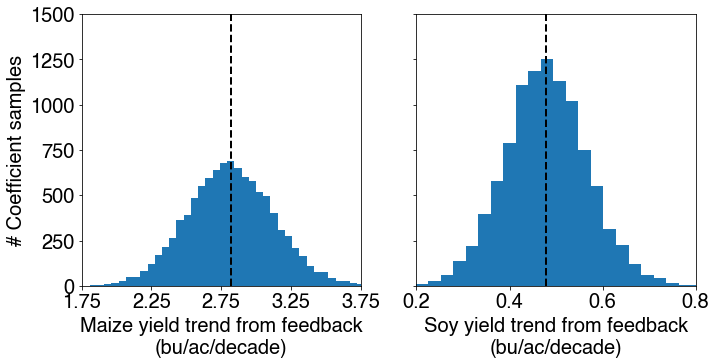

In [73]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(11,5))

maizeYieldFromFeedback_uncert_1d = np.reshape(maizeYieldFromFeedback, [maizeYieldFromFeedback.shape[0], maizeYieldFromFeedback.shape[1]*maizeYieldFromFeedback.shape[2]])
soybeanYieldFromFeedback_uncert_1d = np.reshape(soybeanYieldFromFeedback, [soybeanYieldFromFeedback.shape[0], soybeanYieldFromFeedback.shape[1]*soybeanYieldFromFeedback.shape[2]])

ax1.hist(np.nanmean(maizeYieldFromFeedback_uncert_1d, axis=0), bins=50)
ax1.set_ylim([0, 1500])
ax1.set_xlim([1.75, 3.75])
ax1.plot([np.nanmean(np.nanmean(maizeYieldFromFeedback_uncert_1d)), np.nanmean(np.nanmean(maizeYieldFromFeedback_uncert_1d))], [0, 1500], '--k', lw=2)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_xticks([1.75, 2.25, 2.75, 3.25, 3.75])
ax1.set_xlabel('Maize yield trend from feedback\n(bu/ac/decade)', fontsize=20)
ax1.set_ylabel('# Coefficient samples', fontsize=20)


ax2.set_xlim([0.2, 0.8])
ax2.set_ylim([0, 1500])
ax2.hist(np.nanmean(soybeanYieldFromFeedback_uncert_1d, axis=0), bins=25)
ax2.plot([np.nanmean(np.nanmean(soybeanYieldFromFeedback_uncert_1d)), np.nanmean(np.nanmean(soybeanYieldFromFeedback_uncert_1d))], [0, 1500], '--k', lw=2)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xticks([.2, .4, .6, .8])
ax2.set_xlabel('Soy yield trend from feedback\n(bu/ac/decade)', fontsize=20)
# ax2.set_ylabel('# Coefficient samples', fontsize=20)

# plt.savefig('yield-trend-from-feedback-uncertainty-range.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [18]:
# plt.hist(mdl_LH_Y_CondNum)

In [19]:
# scipy.stats.ks_2samp(maizeYieldFromFeedback_SSA, maizeYieldFromFeedback)

NameError: name 'maizeYieldFromFeedback_SSA' is not defined

In [ ]:

# plt.figure(figsize=(6,6))
# plt.ylim([0,3.7])
# plt.plot(areaLimit, np.nanmedian(maizeYieldFromFeedback_SensTest,axis=0), label='Maize')
# plt.plot(areaLimit, np.nanmedian(soybeanYieldFromFeedback_SensTest,axis=0), label='Soy')
# plt.plot([30,30],[0,3.7], '--k')
# plt.xlabel('Minimum harvested fraction (%)',fontsize=20)
# plt.ylabel('Median feedback yield effect\n(bu/ac/decade)', fontsize=20)
# plt.xticks([10,20,30,40,50,60])
# plt.tick_params(axis='x', labelsize=20)
# plt.tick_params(axis='y', labelsize=20)
# l1 = plt.legend(prop = {'size':20, 'family':'Helvetica'})
# l1.get_frame().set_linewidth(0)
# # plt.savefig('feedback-ha-sens-test.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)


In [33]:
# calculate mean yield, kdd, gdd, and trends across all counties to use for percent corrections in maps below

curCountyList = usCounties.copy()

countyAcAll = np.array([np.nanmean(a) for a in usCounties['maizeCountyArea']])
haMaizeAllAc = np.array([np.nanmean(a) for a in usCounties['maizeHarvestedArea']])
haSoybeanAllAc = np.array([np.nanmean(a) for a in usCounties['soybeanHarvestedArea']])
haTotalAllAc = haMaizeAllAc + haSoybeanAllAc
haAllFrac = np.array([np.nanmean(a) for a in usCounties['maizeHarvestedAreaFraction']])*100
irAggAll = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])
kddTrendAll = np.array([a for a in usCounties['kddTrend']])*10
gddTrendAll = np.array([a for a in usCounties['gddTrend']])*10
prTrendAll = np.array([a for a in usCounties['seasonalPrecipTrend']])*10

countyAcAll = np.array([np.nanmean(a) for a in usCounties['maizeCountyArea']])
haMaizeMeanAllAc = np.array([np.nanmean(a) for a in usCounties['maizeHarvestedArea']])
haSoybeanMeanAllAc = np.array([np.nanmean(a) for a in usCounties['soybeanHarvestedArea']])
haTotalAllAc = haMaizeMeanAllAc + haSoybeanMeanAllAc
haTotalFracAll = haTotalAllAc/countyAcAll

meanPrAll = np.array([np.nanmean(a) for a in usCounties['seasonalPrecip']])

meanNetRadAll = np.array([np.nanmean(a) for a in usCounties['seasonalNetRad']])
meanSlhfAll = -np.array([np.nanmean(a) for a in usCounties['seasonalSlhf']])

if wxData == 'era5':
    countySeasonLenSec = np.array(list(curCountyList['seasonalSeconds']))
    meanNetRadAll /= countySeasonLenSec
    meanSlhfAll /= countySeasonLenSec

meanKddAll = np.array([np.nanmean(a) for a in usCounties['kdd']])
meanGddAll = np.array([np.nanmean(a) for a in usCounties['gdd']])

# convert slhf trend to w/m2/decade
slhfTrendAll = -np.array([a for a in usCounties['seasonalSlhfTrend']])
sshfTrendAll = -np.array([a for a in usCounties['seasonalSshfTrend']])
netRadTrendAll = np.array([a for a in usCounties['seasonalNetRadTrend']])

if wxData == 'era5':
    slhfTrendAll = [a*10/t for a,t in zip(slhfTrendAll, countySeasonLenSec)]
    sshfTrendAll = [a*10/t for a,t in zip(sshfTrendAll, countySeasonLenSec)]
    netRadTrendAll = [a*10/t for a,t in zip(netRadTrendAll, countySeasonLenSec)]

if useDeepak:
    yieldTrendAll = np.array([a for a in usCounties['maizeYieldTrendDeepak']])
    meanYieldAll = np.nanmean(np.array([a for a in usCounties['maizeYieldDeepak']]), axis=1)
    meanProdAll = meanYieldAll * haAllAc
else:
    maizeYieldTrendAll = np.array([a for a in usCounties['maizeYieldTrend']])*10
    maizeYieldAll = np.array([a for a in usCounties['maizeYield']])
    maizeYieldMeanAll = np.nanmean(np.array([a for a in usCounties['maizeYield']]), axis=1)
    
    soybeanYieldTrendAll = np.array([a for a in usCounties['soybeanYieldTrend']])*10
    soybeanYieldAll = np.array([a for a in usCounties['soybeanYield']])
    soybeanYieldStdAll = np.array([np.nanstd(a) for a in usCounties['soybeanYield']])
    soybeanYieldMeanAll = np.nanmean(np.array([a for a in usCounties['soybeanYield']]), axis=1)
    
    maizeYieldStdAll = np.full(maizeYieldTrendAll.shape, np.nan)
    soybeanYieldStdAll = np.full(maizeYieldTrendAll.shape, np.nan)
    for c in range(maizeYieldAll.shape[0]):
        nn = np.where(~np.isnan(maizeYieldAll[c,:]))[0]
        if np.nansum(maizeYieldAll[c,nn]) > 0:
            maizeYieldStdAll[c] = np.nanstd(scipy.signal.detrend(maizeYieldAll[c,nn]))
        
        nn = np.where(~np.isnan(soybeanYieldAll[c,:]))[0]
        if np.nansum(soybeanYieldAll[c,nn]) > 0:
            soybeanYieldStdAll[c] = np.nanstd(scipy.signal.detrend(soybeanYieldAll[c,nn]))
    
    countyMaizeHaAc = np.array([a for a in np.array(list(usCounties['maizeHarvestedArea']))])
    countySoybeanHaAc = np.array([a for a in np.array(list(usCounties['soybeanHarvestedArea']))])
    
    totalProdMeanAll = np.array([x[0]*np.nanmean(x[1]) for x in zip(maizeYieldMeanAll, countyMaizeHaAc)]) + np.array([x[0]*np.nanmean(x[1]) for x in zip(soybeanYieldMeanAll, countySoybeanHaAc)])
    maizeProdMeanAll = np.array([x[0]*np.nanmean(x[1]) for x in zip(maizeYieldMeanAll, countyMaizeHaAc)])
    totalProdMeanLast5All = np.full(totalProdMeanAll.shape, np.nan)
    totalProdTrendAll = np.full(totalProdMeanAll.shape, np.nan)
    totalProdOverTimeAll = np.full(maizeYieldAll.shape[1]-1, 0)
    totalHaTrendAll = np.full(totalProdMeanAll.shape, np.nan)
    for c in range(totalProdMeanAll.size):
        p_maize = np.array([x[0]*x[1] for x in zip(maizeYieldAll[c,:], countyMaizeHaAc[c,:])])
        p_soybean = np.array([x[0]*x[1] for x in zip(soybeanYieldAll[c,:], countySoybeanHaAc[c,:])])
        nn_maize = np.where(~np.isnan(p_maize))[0]
        nn_soybean = np.where(~np.isnan(p_soybean))[0]
        
        totalProdMeanLast5All[c] = np.nanmean(p_maize[nn_maize[-5:]]) + np.nanmean(p_soybean[nn_soybean[-5:]])
        
        for y in range(totalProdOverTimeAll.shape[0]):
            if ~np.isnan(p_maize[y]):
                totalProdOverTimeAll[y] += p_maize[y]
            if ~np.isnan(p_soybean[y]):
                totalProdOverTimeAll[y] += p_soybean[y]
        
        if len(nn_maize) >= 10:
            X =  sm.add_constant(range(len(nn_maize)))
            mdl = sm.OLS(p_maize[nn_maize],X).fit()
            totalProdTrendAll[c] = mdl.params[1]
            
            X =  sm.add_constant(range(len(nn_maize)))
            mdl = sm.OLS(countyMaizeHaAc[c,nn_maize],X).fit()
            totalHaTrendAll[c] = mdl.params[1]
        if len(nn_soybean) >= 10:
            X =  sm.add_constant(range(len(nn_soybean)))
            mdl = sm.OLS(p_soybean[nn_soybean],X).fit()
            if np.isnan(totalProdTrendAll[c]):
                totalProdTrendAll[c] = mdl.params[1]
            else:
                totalProdTrendAll[c] += mdl.params[1]
            
            X =  sm.add_constant(range(len(nn_soybean)))
            mdl = sm.OLS(countySoybeanHaAc[c, nn_soybean],X).fit()
            if np.isnan(totalProdTrendAll[c]):
                totalHaTrendAll[c] = mdl.params[1]
            else:
                totalHaTrendAll[c] += mdl.params[1]

nn = np.where((totalProdTrendAll > 0) & \
              (~np.isnan(np.nanmedian(np.nanmedian(lhFromFeedback,axis=2), axis=1))) & \
              (~np.isnan(haTotalFracAll)) & \
              (np.nansum(mdl_LH_Y_PValues['TotalProd_DetrendAnom'] < 0.05, axis=1) > 50))[0]

nnIr = np.where((totalProdTrendAll > 0) & \
                (~np.isnan(np.nanmedian(np.nanmedian(lhFromFeedback,axis=2), axis=1))) & \
                (~np.isnan(haTotalFracAll)) & (~np.isnan(irSel)) & \
                (np.nansum(mdl_LH_Y_PValues['TotalProd_DetrendAnom'] < 0.05, axis=1) > 50))[0]

nnNonIr = np.where((totalProdTrendAll > 0) & \
                   (~np.isnan(np.nanmedian(np.nanmedian(lhFromFeedback,axis=2), axis=1))) & \
                   (~np.isnan(haTotalFracAll)) & \
                   (np.isnan(irSel)) & \
                   (np.nansum(mdl_LH_Y_PValues['TotalProd_DetrendAnom'] < 0.05, axis=1) > 50))[0]

nnAll = np.where((~np.isnan(np.nanmedian(np.nanmedian(lhFromFeedback,axis=2), axis=1))) & \
                   (~np.isnan(haTotalFracAll)) & \
                   (np.isnan(irSel)))[0]
# noOutlierInd = np.where((abs(scipy.stats.zscore(lhFromFeedback[nn]/haTotalFracAll[nn])) < 1))[0]
adjNn = nn#[noOutlierInd]
# adjNnIr = np.intersect1d(adjNn, irSel)


In [24]:
# split by north/south region by selecting counties w kdd trends > 0 and < 0

ind_kdd_neg = np.where(kddTrendAll[adjNn]<0)[0]
ind_kdd_pos = np.where(kddTrendAll[adjNn]>=0)[0]

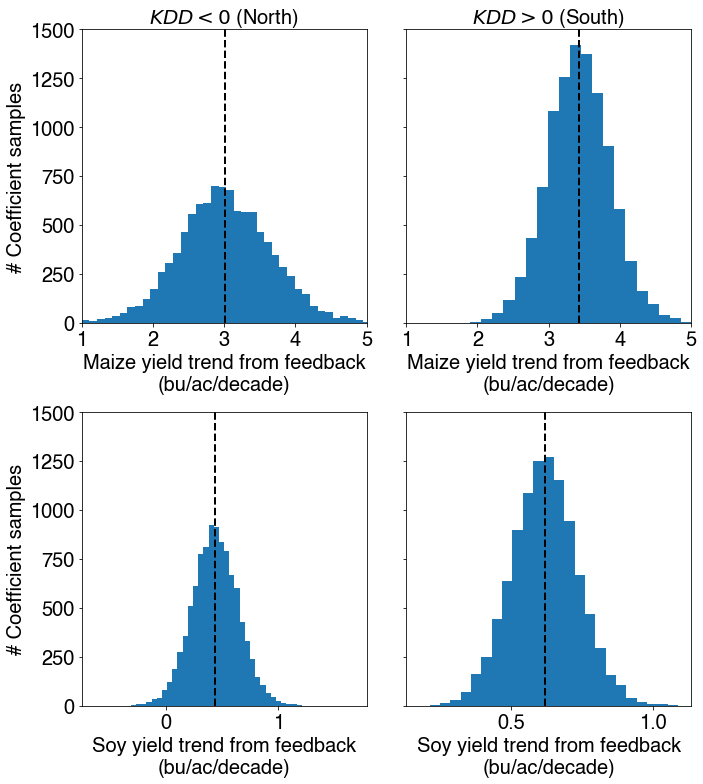

In [75]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, figsize=(10,11))

maizeYieldFromFeedback_kdd_neg_uncert_1d = np.reshape(maizeYieldFromFeedback[adjNn[ind_kdd_neg],:,:], [ind_kdd_neg.size, maizeYieldFromFeedback.shape[1]*maizeYieldFromFeedback.shape[2]])
maizeYieldFromFeedback_kdd_pos_uncert_1d = np.reshape(maizeYieldFromFeedback[adjNn[ind_kdd_pos],:,:], [ind_kdd_pos.size, maizeYieldFromFeedback.shape[1]*maizeYieldFromFeedback.shape[2]])

soybeanYieldFromFeedback_kdd_neg_uncert_1d = np.reshape(soybeanYieldFromFeedback[adjNn[ind_kdd_neg],:,:], [ind_kdd_neg.size, soybeanYieldFromFeedback.shape[1]*soybeanYieldFromFeedback.shape[2]])
soybeanYieldFromFeedback_kdd_pos_uncert_1d = np.reshape(soybeanYieldFromFeedback[adjNn[ind_kdd_pos],:,:], [ind_kdd_pos.size, soybeanYieldFromFeedback.shape[1]*soybeanYieldFromFeedback.shape[2]])

ax1.hist(np.nanmean(maizeYieldFromFeedback_kdd_neg_uncert_1d, axis=0), bins=50)
ax1.set_ylim([0, 1500])
ax1.set_xlim([1, 5])
ax1.plot([np.nanmean(np.nanmean(maizeYieldFromFeedback_kdd_neg_uncert_1d)), np.nanmean(np.nanmean(maizeYieldFromFeedback_kdd_neg_uncert_1d))], [0, 1500], '--k', lw=2)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_title('$KDD < 0$ (North)', fontsize=20)
ax1.set_xlabel('Maize yield trend from feedback\n(bu/ac/decade)', fontsize=20)
ax1.set_ylabel('# Coefficient samples', fontsize=20)

ax2.set_ylim([0, 1500])
ax2.set_xlim([1,5])
ax2.hist(np.nanmean(maizeYieldFromFeedback_kdd_pos_uncert_1d, axis=0), bins=25)
ax2.plot([np.nanmean(np.nanmean(maizeYieldFromFeedback_kdd_pos_uncert_1d)), np.nanmean(np.nanmean(maizeYieldFromFeedback_kdd_pos_uncert_1d))], [0, 1500], '--k', lw=2)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_title('$KDD > 0$ (South)', fontsize=20)
ax2.set_xlabel('Maize yield trend from feedback\n(bu/ac/decade)', fontsize=20)

ax3.hist(np.nanmean(soybeanYieldFromFeedback_kdd_neg_uncert_1d, axis=0), bins=50)
# ax3.set_ylim([0, 1300])
# ax3.set_xlim([1.75, 4.25])
ax3.plot([np.nanmean(np.nanmean(soybeanYieldFromFeedback_kdd_neg_uncert_1d)), np.nanmean(np.nanmean(soybeanYieldFromFeedback_kdd_neg_uncert_1d))], [0, 1500], '--k', lw=2)
ax3.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)
# ax3.set_title('$KDD < 0$ (North)', fontsize=20)
ax3.set_xlabel('Soy yield trend from feedback\n(bu/ac/decade)', fontsize=20)
ax3.set_ylabel('# Coefficient samples', fontsize=20)

# ax4.set_ylim([0, 1300])
# ax4.set_xlim([1.75, 4.25])
ax4.hist(np.nanmean(soybeanYieldFromFeedback_kdd_pos_uncert_1d, axis=0), bins=25)
ax4.plot([np.nanmean(np.nanmean(soybeanYieldFromFeedback_kdd_pos_uncert_1d)), np.nanmean(np.nanmean(soybeanYieldFromFeedback_kdd_pos_uncert_1d))], [0, 1500], '--k', lw=2)
ax4.tick_params(axis='x', labelsize=20)
ax4.tick_params(axis='y', labelsize=20)
# ax4.set_title('$KDD > 0$ (South)', fontsize=20)
ax4.set_xlabel('Soy yield trend from feedback\n(bu/ac/decade)', fontsize=20)

f.tight_layout()

# plt.savefig('yield-trend-from-feedback-uncertainty-range-kdd-pos-neg.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [49]:
np.nanmean(soybeanYieldFromFeedback_kdd_neg_uncert_1d)

0.4289078276793725

In [23]:
def polyfit(x, y, degree):
    results = {}
    coeffs = np.polyfit(x, y, degree)
    p = np.poly1d(coeffs)
    #calculate r-squared
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    results['r_squared'] = ssreg / sstot
    return results

In [54]:
totalProdOverTime_Maize_sel = np.nansum(totalProdOverTime_Maize[adjNn,:],axis=0)*56
totalProdOverTime_Soy_sel = np.nansum(totalProdOverTime_Soy[adjNn,:],axis=0)*60

totalProdOverTimeAll_sel_lbs = totalProdOverTime_Maize_sel+totalProdOverTime_Soy_sel

print(np.corrcoef(totalProdOverTime_Maize_sel, totalProdOverTime_Soy_sel))
print(np.corrcoef(totalProdOverTimeAll_sel_lbs, totalProdOverTimeAll_sel))

# plt.scatter(totalProdOverTime_Maize_sel, totalProdOverTime_Soy_sel)

[[1.         0.86759201]
 [0.86759201 1.        ]]
[[1.         0.99998426]
 [0.99998426 1.        ]]


Text(0, 0.5, 'Maize + soy production\n(billions of bushels)')

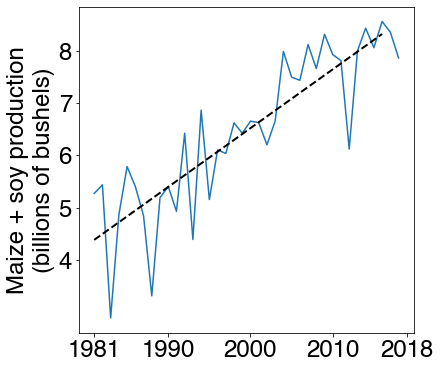

In [25]:
totalProdOverTimeAll_sel = np.nansum(totalProdOverTimeAll[adjNn,:],axis=0)

X = sm.add_constant(range(len(totalProdOverTimeAll_sel)))
mdl = sm.OLS(totalProdOverTimeAll_sel, X).fit()

x1 = 0
x2 = 35

plt.figure(figsize=(6,6))
plt.plot(totalProdOverTimeAll_sel)
plt.plot([x1, x2], [mdl.params[0], mdl.params[0]+x2*mdl.params[1]], '--k', lw=2)
plt.xticks([0, 9, 19, 29, 38])
plt.gca().set_xticklabels([1981, 1990, 2000, 2010, 2018])

plt.yticks([.4e10, .5e10, .6e10, .7e10, .8e10])
plt.gca().set_yticklabels([4,5,6,7,8])

plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)

plt.ylabel('Maize + soy production\n(billions of bushels)', fontsize=24)
# plt.savefig('prod-growth-linear-trend.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [26]:
mdl.params[1]/1e6

112.76786587055479

In [27]:
# r2 of linear vs quadratic fit on prod data
print(polyfit(range(len(totalProdOverTimeAll_sel)), totalProdOverTimeAll_sel, 1))

{'r_squared': 0.7371959287102703}


In [35]:
# lh from feedback uncert
lhFromFeedback_1d = np.nanmean(lhFromFeedback[adjNn,:,:], axis=0)
lhFromFeedback_1d = np.reshape(lhFromFeedback_1d, [lhFromFeedback_1d.size,1])

print(len(adjNn))
print(np.nanmean(lhFromFeedback[adjNn,:,:]))
print(np.nanpercentile(lhFromFeedback_1d, 5), np.nanpercentile(lhFromFeedback_1d, 95))

376
2.2207790380373456
0.806132820040651 3.632434873549259


In [37]:
# feedback strngth for irrigated counties
maizeYieldFromFeedback_irr_1d = np.nanmean(maizeYieldFromFeedback[nnIr,:,:], axis=0)
maizeYieldFromFeedback_irr_1d = np.reshape(maizeYieldFromFeedback_irr_1d, [maizeYieldFromFeedback_irr_1d.size,1])

print(len(nnIr))
print(np.nanmean(maizeYieldFromFeedback[nnIr,:,:]))
print(np.nanpercentile(maizeYieldFromFeedback_irr_1d, 5), np.nanpercentile(maizeYieldFromFeedback_irr_1d, 95))

52
3.100532124771967
1.3110859731593256 4.9608810014271


In [38]:
# feedback strngth for non irrigated counties
maizeYieldFromFeedback_no_irr_1d = np.nanmean(maizeYieldFromFeedback[nnNonIr,:,:], axis=0)
maizeYieldFromFeedback_no_irr_1d = np.reshape(maizeYieldFromFeedback_no_irr_1d, [maizeYieldFromFeedback_no_irr_1d.size,1])

print(len(nnNonIr))
print(np.nanmean(maizeYieldFromFeedback[nnNonIr,:,:]))
print(np.nanpercentile(maizeYieldFromFeedback_no_irr_1d, 5), np.nanpercentile(maizeYieldFromFeedback_no_irr_1d, 95))

324
3.352268637762772
2.720261495215189 3.9747222168394463


In [39]:
# feedback strngth for all counties
maizeYieldFromFeedback_1d = np.nanmean(maizeYieldFromFeedback[adjNn,:,:], axis=0)
maizeYieldFromFeedback_1d = np.reshape(maizeYieldFromFeedback_1d, [maizeYieldFromFeedback_1d.size,1])

print('maize')
print(len(adjNn))
print(np.nanmean(maizeYieldFromFeedback[adjNn,:,:]))
print(np.nanpercentile(maizeYieldFromFeedback_1d, 5), np.nanpercentile(maizeYieldFromFeedback_1d, 95))


soybeanYieldFromFeedback_1d = np.nanmean(soybeanYieldFromFeedback[adjNn,:,:], axis=0)
soybeanYieldFromFeedback_1d = np.reshape(soybeanYieldFromFeedback_1d, [soybeanYieldFromFeedback_1d.size,1])

print()
print('soy')
print(len(adjNn))
print(np.nanmean(soybeanYieldFromFeedback[adjNn,:,:]))
print(np.nanpercentile(soybeanYieldFromFeedback_1d, 5), np.nanpercentile(soybeanYieldFromFeedback_1d, 95))

maize
376
3.31745401362575
2.7193215283705996 3.9131229463388224

soy
376
0.5744683787249404
0.40606097601864694 0.7442050795476121


In [35]:

# these are in w/m2 per million bu
print(np.nanmean(mdl_LH_Y_Coefs['TotalProd_DetrendAnom'][nnNonIr, :]))
print(np.nanmean(mdl_LH_Y_Coefs['TotalProd_DetrendAnom'][nnIr, :]))

0.7508558545206142
0.8903423359795547


In [30]:
len(nnIr)/len(adjNn)

0.13829787234042554

In [34]:
# all counties meeting critieria except for coef significance
nnAll.shape

(398,)

In [29]:
# counties meeting critieria and have sig coeff
adjNn.shape

(376,)

In [39]:
# median prod coefficient value
np.nanmean(mdl_LH_Y_Coefs['TotalProd_DetrendAnom'][adjNn, :])

0.7699938414226325

In [48]:
NYears = usCounties['seasonalPrecip'][2].size

In [26]:
# fraction counties with positive signficant prod coefficient

nnSig = np.where((mdl_LH_Y_PValues['TotalProd_DetrendAnom'][adjNn]<0.05) & (mdl_LH_Y_Coefs['TotalProd_DetrendAnom'][adjNn]>0))[0]
len(nnSig)/len(adjNn)


0.990909090909091

In [42]:
# fraction of prod in counties w/ positive and sig. prod coefficient
np.nansum(totalProdMeanAll[adjNn[nnSig]])/np.nansum(totalProdMeanAll[adjNn])

1.0

In [43]:
# median lh r2 value

np.nanmedian(mdl_LH_Y_Coefs['R2'][adjNn])

0.7810823794586302

In [31]:
# total maize/soy production in included counties
np.nansum(totalProdMeanAll[adjNn])/np.nansum(totalProdMeanAll)

0.5938917042576569

In [32]:
# % production occurring in counties with > 50% harvested area
indHa = np.where((haTotalAllAc[adjNn]/countyAcAll[adjNn]>.5))[0]
np.nansum(totalProdMeanAll[adjNn[indHa]])/np.nansum(totalProdMeanAll[adjNn])

0.8124334136803063

In [48]:
nn = np.where(~np.isnan(mdl_KDD_GDD_SoybeanYield_Coefs['KDD_Detrend']))[0]
ind = np.where(mdl_KDD_GDD_SoybeanYield_Coefs['KDD_Detrend'][nn]>0)[0]
len(ind)/len(mdl_KDD_GDD_SoybeanYield_Coefs['KDD_Detrend'][nn])

NameError: name 'mdl_KDD_GDD_SoybeanYield_Coefs' is not defined

In [ ]:
nn = np.where(~np.isnan(mdl_KDD_GDD_SoybeanYield_PValues['Pr_Detrend']))[0]
ind = np.where(mdl_KDD_GDD_SoybeanYield_PValues['Pr_Detrend'][nn]<0.05)[0]
len(ind)/len(mdl_KDD_GDD_SoybeanYield_PValues['Pr_Detrend'][nn])

In [ ]:
#     mdl_Param_Corr['Prod-Pr'][i] = np.corrcoef(dfProd['TotalProd_DetrendAnom'], dfProd['Pr_DetrendAnom'])[0,1]
#     mdl_Param_Corr['Prod-NetRad'][i] = np.corrcoef(dfProd['TotalProd_DetrendAnom'], dfProd['NetRad_DetrendAnom'])[0,1]
#     mdl_Param_Corr['Prod-Wind'][i] = np.corrcoef(dfProd['TotalProd_DetrendAnom'], dfProd['Wind_DetrendAnom'])[0,1]
#     mdl_Param_Corr['Pr-NetRad'][i] = np.corrcoef(dfProd['Pr_DetrendAnom'], dfProd['NetRad_DetrendAnom'])[0,1]
#     mdl_Param_Corr['Pr-Wind'][i] = np.corrcoef(dfProd['Pr_DetrendAnom'], dfProd['Wind_DetrendAnom'])[0,1]
#     mdl_Param_Corr['NetRad-Wind'][i] = np.corrcoef(dfProd['NetRad_DetrendAnom'], dfProd['Wind_DetrendAnom'])[0,1]
var='Prod-Wind'
nn = np.where(~np.isnan(mdl_Param_Corr[var]))[0]
plt.hist(mdl_Param_Corr[var][nn])
np.nanmedian(mdl_Param_Corr[var])
# scipy.stats.ttest_1samp(mdl_Param_Corr[var][nn], 0)

In [ ]:
(1-110/170)*450*2.26e6/np.nanmean(countySeasonLenSec)/NYears*10

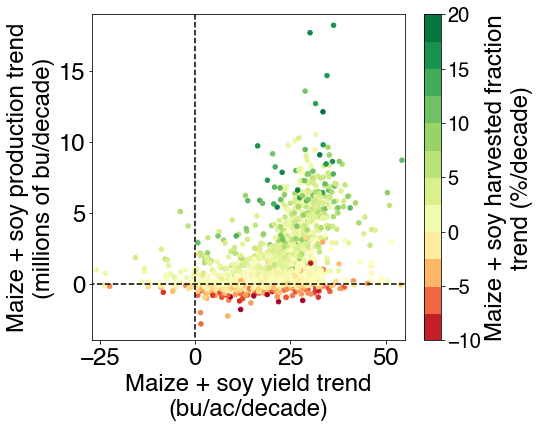

In [49]:
nn = np.where((~np.isnan(totalProdTrendAll)) & (~np.isnan(soybeanYieldTrendAll + maizeYieldTrendAll)) & (~np.isnan(totalHaTrendAll)))[0]

data = {'meanProd':totalProdMeanAll[nn], \
        'prodTrend':totalProdTrendAll[nn]/1e6*10, \
        'yieldTrend':soybeanYieldTrendAll[nn] + maizeYieldTrendAll[nn], \
        'haTrend':totalHaTrendAll[nn]/countyAcAll[nn]*100*10}
                        
df = pd.DataFrame(data, \
                  columns=['prodTrend', 'yieldTrend', 'haTrend'])
prodDriversMdl = smf.ols(formula='prodTrend ~ yieldTrend + haTrend', data=df).fit()
# prodDriversMdl.summary()

midnorm = MidpointNormalize(vmin=-10, vcenter=0, vmax=20)

# plt.scatter(data['haTrend'], data['prodTrend'])
fig = plt.figure(figsize=(7, 6))
plt.xlim([-27, 55])
plt.ylim([-4, 19])
a = plt.scatter(data['yieldTrend'], data['prodTrend'], c=data['haTrend'], cmap='RdYlGn', s = 20, norm=midnorm)
plt.plot([-30, 75], [0, 0], '--k')
plt.plot([0, 0], [-10, 20], '--k')

plt.xlabel('Maize + soy yield trend\n(bu/ac/decade)', fontsize=24)
plt.ylabel('Maize + soy production trend\n(millions of bu/decade)', fontsize=24)
plt.xticks([-25, 0, 25, 50])
plt.yticks([0, 5, 10, 15])
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)

cbar = fig.colorbar(a, ax=plt.gca(),
                    ticks=np.arange(-10, 20.1, 5), boundaries=np.arange(-10, 20.1, 2.5))
cbar.set_label('Maize + soy harvested fraction\ntrend (%/decade)', fontsize=24)
cbar.ax.tick_params(labelsize=20)
# plt.savefig('us-prod-trend-vs-yield-trend-scatter-colorbar.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)
# plt.scatter(totalHaTrendAll, soybeanYieldTrendAll + maizeYieldTrendAll)
# plt.scatter(soybeanYieldTrendAll + maizeYieldTrendAll, totalProdTrendAll)

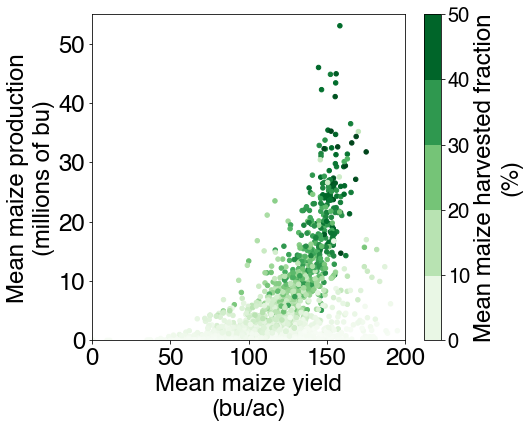

In [50]:
nn = np.where((~np.isnan(maizeProdMeanAll)) & (~np.isnan(maizeYieldMeanAll)) & (~np.isnan(np.nanmean(countyMaizeHaAc, axis=1))))[0]

data = {'meanMaizeProd':maizeProdMeanAll[nn]/1e6, \
        'meanMaizeYield':maizeYieldMeanAll[nn], \
        'meanMaizeHa':np.nanmean(countyMaizeHaAc[nn, :], axis=1)/countyAcAll[nn]*100}
                        
df = pd.DataFrame(data, \
                  columns=['meanMaizeProd', 'meanMaizeYield', 'meanMaizeHa'])
# prodDriversMdl = smf.ols(formula='prodTrend ~ yieldTrend + haTrend', data=df).fit()
# prodDriversMdl.summary()

v1 = 0
v2 = 50.1
vcenter = (v1+v2)/2

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

# plt.scatter(data['haTrend'], data['prodTrend'])
fig = plt.figure(figsize=(7, 6))
plt.xlim([0, 200])
plt.ylim([0, 55])
a = plt.scatter(data['meanMaizeYield'], data['meanMaizeProd'], c=data['meanMaizeHa'], cmap='Greens', s = 20, norm=midnorm)
# plt.plot([0, 200], [0, 0], '--k')
# plt.plot([0, 0], [-10, 20], '--k')

plt.xlabel('Mean maize yield\n(bu/ac)', fontsize=24)
plt.ylabel('Mean maize production\n(millions of bu)', fontsize=24)
plt.xticks(np.arange(0, 201, 50))
plt.yticks(np.arange(0, 51, 10))
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)

cbar = fig.colorbar(a, ax=plt.gca(),
                    ticks=np.arange(v1, v2, 10), boundaries=np.arange(v1, v2, 10))
cbar.set_label('Mean maize harvested fraction\n(%)', fontsize=24)
cbar.ax.tick_params(labelsize=20)
# plt.savefig('us-maize-prod-vs-yield-scatter-vs-ha-colorbar.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)
# plt.scatter(totalHaTrendAll, soybeanYieldTrendAll + maizeYieldTrendAll)
# plt.scatter(soybeanYieldTrendAll + maizeYieldTrendAll, totalProdTrendAll)

In [60]:

# production benefit from ag-int
# maizeYieldFromFeedback is in bu/ac/decade
maizeProdFromFeedback = np.reshape(np.nanmean(np.nanmean(maizeYieldFromFeedback, axis=2), axis=1), [maizeYieldFromFeedback.shape[0], 1]) * NYears/10 * haMaizeAllAc
soybeanProdFromFeedback = np.reshape(np.nanmean(np.nanmean(soybeanYieldFromFeedback, axis=2), axis=1), [soybeanYieldFromFeedback.shape[0], 1]) * NYears/10 * haSoybeanAllAc
print('maize from feedback (M bu): %.2f, (MT): %.2f'%((np.nansum(maizeProdFromFeedback[adjNn,:])/1e6), (np.nansum(maizeProdFromFeedback[adjNn,:])/1000)*.0254))
print('soy (M bu): %.2f, (MT): %.2f'%(np.nansum(soybeanProdFromFeedback[adjNn,:])/1e6, np.nansum(soybeanProdFromFeedback[adjNn,:])/1000*.0272155))#*27/1000/1000))

maize from feedback (M bu): 355197.35, (MT): 9022012.63
soy (M bu): 58013.39, (MT): 1578863.33


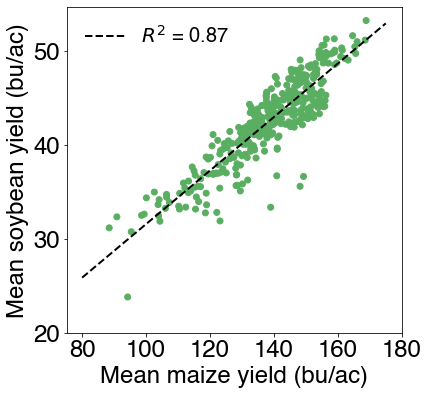

In [63]:
cmap = plt.cm.get_cmap('PRGn')
mmean = np.nanmean(countyMaizeYield,axis=1)
smean = np.nanmean(countySoybeanYield,axis=1)

# nn = np.where((~np.isnan(mmean)) & (~np.isnan(smean)))[0]

X = sm.add_constant(mmean[adjNn])
mdl = sm.OLS(smean[adjNn], X).fit()

x1 = 80
x2 = 175

plt.figure(figsize=(6,6))
plt.scatter(mmean[adjNn],smean[adjNn],c=[cmap(.8)]*len(adjNn))
plt.plot([x1, x2], mdl.params[0]+[x1*mdl.params[1], x2*mdl.params[1]], '--k', lw=2, label = '$R^2$ = 0.87')
plt.xlabel('Mean maize yield (bu/ac)', fontsize=24)
plt.xticks(np.arange(80, 181, 20))
plt.ylabel('Mean soybean yield (bu/ac)', fontsize=24)
plt.yticks([20, 30, 40, 50])
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
l1 = plt.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
# plt.savefig('maize-soy-mean-yield-scatter.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

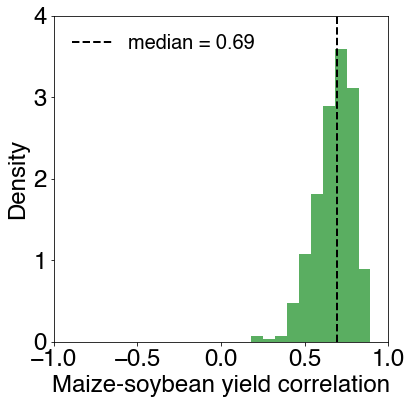

In [64]:
# correlation between maize and soy yields

mc = []
for c in range(countySoybeanYield.shape[0]):
    nn = np.where((~np.isnan(countySoybeanYield[c,:])) & (~np.isnan(countyMaizeYield[c,:])))[0]
    if len(nn) > 0:
        soybeanYieldDt = scipy.signal.detrend(countySoybeanYield[c, nn])
        maizeYieldDt = scipy.signal.detrend(countyMaizeYield[c,nn])
        mc.append(np.corrcoef(soybeanYieldDt, maizeYieldDt)[0,1])
    else:
        mc.append(np.nan)
mc = np.array(mc)
plt.figure(figsize=(6,6))
plt.ylim([0,4])
plt.hist(mc[adjNn], density=True, facecolor=cmap(.8), bins=10)
plt.plot([np.nanmedian(mc[adjNn]), np.nanmedian(mc[adjNn])], [0, 4], '--k', lw=2, label='median = %.2f'%np.nanmedian(mc[adjNn]))
plt.xlabel('Maize-soybean yield correlation', fontsize=24)
plt.ylabel('Density', fontsize=24)
plt.xticks(np.arange(-1, 1.1, .5))
# plt.yticks([20, 30, 40, 50])
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
l1 = plt.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
# plt.savefig('maize-soy-yield-corr.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

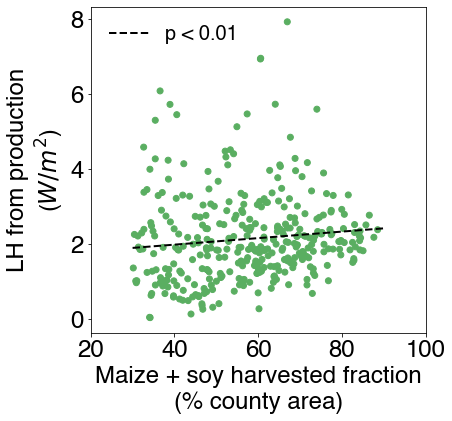

In [72]:
cmap = plt.cm.get_cmap('PRGn')

haFrac = haTotalAllAc/countyAcAll*100

# nn = np.where((~np.isnan(haFrac)) & (haFrac > 20) & (~np.isnan(mdl_LH_Y_Coefs['TotalProd_DetrendAnom'])))[0]

# print('frac < 20%% ha: %.2f'%(len(np.where(haFrac[]<20)[0])/len(nn)))

X = sm.add_constant(haFrac[adjNn])
mdl = sm.OLS(np.nanmean(np.nanmean(lhFromFeedback[adjNn, :, :], axis=2), axis=1), X).fit()

x1 = 30
x2 = 90

plt.figure(figsize=(6,6))
# plt.xlim([-.1,55])
# plt.ylim([-.1,4.5])
plt.scatter(haFrac[adjNn], np.nanmean(np.nanmean(lhFromFeedback[adjNn, :, :], axis=2), axis=1), c = [cmap(.8)]*len(adjNn))
plt.plot([x1, x2], mdl.params[0]+[x1*mdl.params[1], x2*mdl.params[1]], '--k', lw=2, label = 'p < 0.01')
plt.xlabel('Maize + soy harvested fraction\n(% county area)', fontsize=24)
plt.xticks(np.arange(20, 101, 20))
plt.ylabel('LH from production\n($W/m^2$)', fontsize=24)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
l1 = plt.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
# plt.savefig('lh-from-prod-vs-harvested-frac.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
cmap = plt.cm.get_cmap('PRGn')

haFrac = haTotalAllAc/countyAcAll*100

# nn = np.where((~np.isnan(haFrac)) & (haFrac > 20) & (~np.isnan(mdl_LH_Y_Coefs['TotalProd_DetrendAnom'])))[0]

# print('frac < 20%% ha: %.2f'%(len(np.where(haFrac[]<20)[0])/len(nn)))

X = sm.add_constant(haFrac[adjNn])
mdl = sm.OLS(mdl_LH_Y_PValues['TotalProd_DetrendAnom'][adjNn], X).fit()

x1 = 10
x2 = 90

plt.figure(figsize=(6,6))
# plt.xlim([-.1,55])
# plt.ylim([0,.06])
plt.scatter(haFrac[adjNn], mdl_LH_Y_PValues['TotalProd_DetrendAnom'][adjNn], c = [cmap(.8)]*len(adjNn))
plt.plot([x1, x2], mdl.params[0]+[x1*mdl.params[1], x2*mdl.params[1]], '--k', lw=2, label = 'p < 0.01')
plt.xlabel('Maize + soy harvested fraction\n(% county area)', fontsize=24)
plt.xticks(np.arange(0, 101, 20))
plt.ylabel('$\\beta_{Production}$ p-value', fontsize=24)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
l1 = plt.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
# plt.savefig('beta-prod-pval-vs-harvested-frac.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


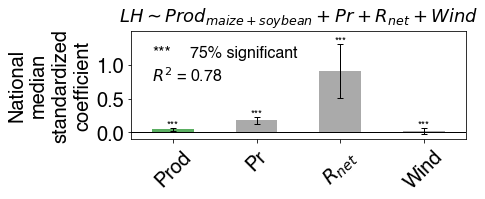

In [20]:
# this enables legends for text objects to show the significance markers
import string
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text, Annotation
from matplotlib.legend import Legend
class TextHandlerA(HandlerBase):
    def create_artists(self, legend, artist ,xdescent, ydescent,
                        width, height, fontsize, trans):
        tx = Text(width/2.,height/2, artist.get_text(), fontsize=fontsize,
                  ha="center", va="center", fontweight="bold")
        return [tx]

Legend.update_default_handler_map({Text : TextHandlerA()})



width = .5
cmap = plt.cm.get_cmap('PRGn')

plt.figure(figsize=(6,2))
plt.xlim([.5,4.5])
if wxData == 'era5':
    plt.ylim([-.1,1.5])
elif wxData == 'gldas':
    plt.ylim([-.1,1.8])

l1_TotalProd = np.nanpercentile(mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm'][adjNn, :],10)
l2_TotalProd = np.nanpercentile(mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm'][adjNn, :],90)
ind_TotalProd = np.where((mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm']>l1_TotalProd) & (mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm']<l2_TotalProd))[0]

xvalues = [1,2,3,4]
yvalues = [np.nanmedian(mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm'][ind_TotalProd]), 
           np.nanmedian(mdl_LH_Y_Norm_Coefs['Pr_DetrendAnom_Norm'][ind_TotalProd]),
           np.nanmedian(mdl_LH_Y_Norm_Coefs['NetRad_DetrendAnom_Norm'][ind_TotalProd]),
           np.nanmedian(mdl_LH_Y_Norm_Coefs['Wind_DetrendAnom_Norm'][ind_TotalProd])]
pvalues = [len(np.where(mdl_LH_Y_Norm_PValues['TotalProd_DetrendAnom_Norm']<0.05)[0])/len(adjNn), 
           len(np.where(mdl_LH_Y_Norm_PValues['Pr_DetrendAnom_Norm']<0.05)[0])/len(adjNn),
           len(np.where(mdl_LH_Y_Norm_PValues['NetRad_DetrendAnom_Norm']<0.05)[0])/len(adjNn),
           len(np.where(mdl_LH_Y_Norm_PValues['Wind_DetrendAnom_Norm']<0.05)[0])/len(adjNn)]
yerrs = [np.nanstd(mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm'][ind_TotalProd]),
         np.nanstd(mdl_LH_Y_Norm_Coefs['Pr_DetrendAnom_Norm'][ind_TotalProd]),
         np.nanstd(mdl_LH_Y_Norm_Coefs['NetRad_DetrendAnom_Norm'][ind_TotalProd]),
         np.nanstd(mdl_LH_Y_Norm_Coefs['Wind_DetrendAnom_Norm'][ind_TotalProd])]

facecolors = [cmap(.8), '#aaaaaa', '#aaaaaa', '#aaaaaa']
b = plt.bar(xvalues, yvalues, width=width, yerr=yerrs, capsize=3, error_kw={'lw':1})
plt.plot([.5, 5.5], [0,0], '-k', lw=1)
plt.xticks([1,2,3,4], rotation=45, fontsize=20)
if wxData == 'era5':
    plt.yticks([0, .5, 1], fontsize=20)
elif wxData == 'gldas':
    plt.yticks([0, .5, 1, 1.5], fontsize=20)
plt.gca().set_xticklabels(['Prod', 'Pr', '$R_{net}$', 'Wind'], fontsize=20)
plt.ylabel('National\nmedian\nstandardized\ncoefficient', fontsize=20)

plt.title('$LH \sim Prod_{maize+soybean} + Pr + R_{net} + Wind$', fontsize=18)

if wxData == 'era5':
    plt.text(.75, .75, '$R^2$ = %0.2f'%(np.nanmedian(mdl_LH_Y_Coefs['R2'][ind_TotalProd])), fontdict = {'size':16, 'family':'Helvetica'})
elif wxData == 'gldas':
    plt.text(.75, .75, '$R^2$ = %0.2f'%(np.nanmedian(mdl_LH_Y_Coefs['R2'][ind_TotalProd])), fontdict = {'size':16, 'family':'Helvetica'})

i = 0
k = 0
errBarLC = b.errorbar.lines[2][0]
for pat, errline, yval, pval, c in zip(b.patches, errBarLC.get_segments(), yvalues, pvalues, facecolors):
    pat.set_facecolor(c)
    
    xpos = errline[0][0]
    if yval >= 0:
        ypos = errline[1][1]
    else:
        ypos = errline[0][1]*1.23
    
    if pval > .75:
        if i == 0:
            t = plt.text(xpos, ypos, '***', ha='center')
        else:
            plt.text(xpos, ypos, '***', ha='center')
        i += 1
    elif pval > .5:
        if k == 0:
            t2 = plt.text(xpos, ypos, '*', ha='center')
        k += 1

if wxData == 'era5':
    leg = plt.legend([t], ['75% significant'], prop = {'size':16, 'family':'Helvetica'}, loc = 'upper left')
elif wxData == 'gldas':
    leg = plt.legend([t], ['75% significant'], prop = {'size':16, 'family':'Helvetica'}, loc = 'upper left')
leg.get_frame().set_linewidth(0.0)
# plt.savefig('reg-coef-lh-yield-nass-%s.eps'%wxData, format='eps', dpi=500, bbox_inches = 'tight', pad_inches = 0)

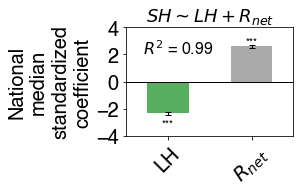

In [22]:
width=.5
cmap = plt.cm.get_cmap('PRGn')

plt.figure(figsize=(3,2))
plt.xlim([.5,2.5])
plt.ylim([-4,4])

xvalues = [1,2]
yvalues = [np.nanmedian(mdl_LH_SH_Norm_Coefs['SLHF_DetrendAnom_Norm'][adjNn]), 
           np.nanmedian(mdl_LH_SH_Norm_Coefs['NetRad_DetrendAnom_Norm'][adjNn])]
pvalues = [len(np.where(mdl_LH_SH_Norm_PValues['SLHF_DetrendAnom_Norm'][adjNn]<0.05)[0])/len(adjNn), 
           len(np.where(mdl_LH_SH_Norm_PValues['NetRad_DetrendAnom_Norm'][adjNn]<0.05)[0])/len(adjNn)]
yerrs = [np.nanstd(mdl_LH_SH_Norm_Coefs['SLHF_DetrendAnom_Norm'][adjNn]),
         np.nanstd(mdl_LH_SH_Norm_Coefs['NetRad_DetrendAnom_Norm'][adjNn])]
facecolors = [cmap(.8), '#aaaaaa', '#aaaaaa', '#aaaaaa', '#aaaaaa']
b = plt.bar(xvalues, yvalues, width=width, yerr=yerrs, capsize=3, error_kw={'lw':1})
plt.plot([.5, 2.5], [0,0], '-k', lw=1)
plt.xticks([1,2], rotation=45, fontsize=20)
plt.yticks([-4, -2, 0, 2, 4], fontsize=20)
plt.gca().set_xticklabels(['LH', '$R_{net}$'], fontsize=20)
plt.ylabel('National\nmedian\nstandardized\ncoefficient', fontsize=20)

plt.title('$SH \sim LH + R_{net}$', fontsize=18)

plt.text(.7, 2, '$R^2$ = %0.2f'%(np.nanmedian(mdl_LH_SH_Coefs['R2'][adjNn])), fontdict = {'size':16, 'family':'Helvetica'})

errBarLC = b.errorbar.lines[2][0]
for pat, errline, yval, pval, c in zip(b.patches, errBarLC.get_segments(), yvalues, pvalues, facecolors):
    pat.set_facecolor(c)
    
    xpos = errline[0][0]
    if yval >= 0:
        ypos = errline[1][1]
    else:
        ypos = errline[0][1]*1.35
    
    if pval > .8:
        plt.text(xpos, ypos, '***', ha='center')
#     elif pval < .05:
#         plt.text(xpos, ypos, '**', ha='center')
#     elif pval < .1:
#         plt.text(xpos, ypos, '*', ha='center')

# plt.savefig('reg-coef-lh-sh-nass-%s.eps'%wxData, format='eps', dpi=500, bbox_inches = 'tight', pad_inches = 0)

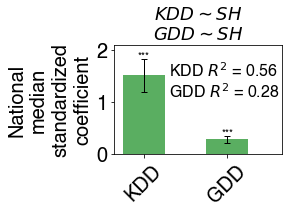

In [24]:
width=.5
cmap = plt.cm.get_cmap('PRGn')

plt.figure(figsize=(3,2))
plt.xlim([.5,2.5])
plt.ylim([0,2.1])

xvalues = [.85,1.85]
yvalues = [np.nanmedian(mdl_SH_KDD_Norm_Coefs['SSHF_DetrendAnom_Norm'][adjNn]), 
           np.nanmedian(mdl_SH_GDD_Norm_Coefs['SSHF_DetrendAnom_Norm'][adjNn])]
pvalues = [len(np.where(mdl_SH_KDD_Norm_PValues['SSHF_DetrendAnom_Norm'][adjNn]<0.05)[0])/len(adjNn), 
           len(np.where(mdl_SH_GDD_Norm_PValues['SSHF_DetrendAnom_Norm'][adjNn]<0.05)[0])/len(adjNn)]
yerrs = [np.nanstd(mdl_SH_KDD_Norm_Coefs['SSHF_DetrendAnom_Norm'][adjNn]),
         np.nanstd(mdl_SH_GDD_Norm_Coefs['SSHF_DetrendAnom_Norm'][adjNn])]
facecolors = [cmap(.8), cmap(.8)]
b = plt.bar(xvalues, yvalues, width=width, yerr=yerrs, capsize=3, error_kw={'lw':1})
plt.plot([.5, 2.5], [0,0], '-k', lw=1)
plt.xticks([.85,1.85], rotation=45, fontsize=20)
plt.yticks([0, 1, 2], fontsize=20)
plt.gca().set_xticklabels(['KDD', 'GDD'], fontsize=20)
plt.ylabel('National\nmedian\nstandardized\ncoefficient', fontsize=20)

plt.title('$KDD \sim SH$\n$GDD \sim SH$', fontsize=18)

plt.text(1.15, 1.5, 'KDD $R^2$ = %0.2f'%(np.nanmedian(mdl_SH_KDD_Coefs['R2'][adjNn])), fontdict = {'size':16, 'family':'Helvetica'})
plt.text(1.15, 1.1, 'GDD $R^2$ = %0.2f'%(np.nanmedian(mdl_SH_GDD_Coefs['R2'][adjNn])), fontdict = {'size':16, 'family':'Helvetica'})

errBarLC = b.errorbar.lines[2][0]
for pat, errline, yval, pval, c in zip(b.patches, errBarLC.get_segments(), yvalues, pvalues, facecolors):
    pat.set_facecolor(c)
    
    xpos = errline[0][0]
    if yval >= 0:
        ypos = errline[1][1]
    else:
        ypos = errline[0][1]*1.23
    
    if pval > .8:
        plt.text(xpos, ypos, '***', ha='center')
#     elif pval < .05:
#         plt.text(xpos, ypos, '**', ha='center')
#     elif pval < .1:
#         plt.text(xpos, ypos, '*', ha='center')

plt.savefig('reg-coef-sh-kdd-gdd-nass-%s.eps'%wxData, format='eps', dpi=500, bbox_inches = 'tight', pad_inches = 0)

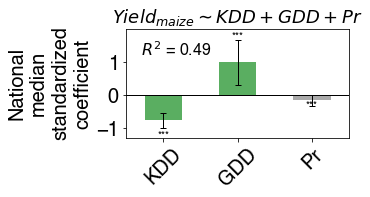

In [26]:
width=.5
cmap = plt.cm.get_cmap('PRGn')

plt.figure(figsize=(4,2))
plt.xlim([.5,3.5])
plt.ylim([-1.3,2])

xvalues = [1,2,3]
yvalues = [np.nanmedian(mdl_KDD_GDD_MaizeYield_Norm_Coefs['KDD_DetrendNorm'][adjNn]), 
           np.nanmedian(mdl_KDD_GDD_MaizeYield_Norm_Coefs['GDD_DetrendNorm'][adjNn]),
           np.nanmedian(mdl_KDD_GDD_MaizeYield_Norm_Coefs['Pr_DetrendNorm'][adjNn])]
pvalues = [len(np.where(mdl_KDD_GDD_MaizeYield_Norm_PValues['KDD_DetrendNorm'][adjNn]<0.05)[0])/len(adjNn), 
           len(np.where(mdl_KDD_GDD_MaizeYield_Norm_PValues['GDD_DetrendNorm'][adjNn]<0.05)[0])/len(adjNn),
           len(np.where(mdl_KDD_GDD_MaizeYield_Norm_PValues['Pr_DetrendNorm'][adjNn]<0.05)[0])/len(adjNn)]
yerrs = [np.nanstd(mdl_KDD_GDD_MaizeYield_Norm_Coefs['KDD_DetrendNorm'][adjNn]), 
         np.nanstd(mdl_KDD_GDD_MaizeYield_Norm_Coefs['GDD_DetrendNorm'][adjNn]),
         np.nanstd(mdl_KDD_GDD_MaizeYield_Norm_Coefs['Pr_DetrendNorm'][adjNn])]
facecolors = [cmap(.8), cmap(.8), '#aaaaaa']
b = plt.bar(xvalues, yvalues, width=width, yerr=yerrs, capsize=3, error_kw={'lw':1})
plt.plot([.5, 3.5], [0,0], '-k', lw=1)
plt.xticks([1,2,3], rotation=45, fontsize=20)
plt.yticks([-1, 0, 1], fontsize=20)
plt.gca().set_xticklabels(['KDD', 'GDD', 'Pr'], fontsize=20)
plt.ylabel('National\nmedian\nstandardized\ncoefficient', fontsize=20)

plt.title('$Yield_{maize} \sim KDD + GDD + Pr$', fontsize=18)

plt.text(.7, 1.2, '$R^2$ = %0.2f'%(np.nanmedian(mdl_KDD_GDD_MaizeYield_Coefs['R2'][adjNn])), fontdict = {'size':16, 'family':'Helvetica'})

errBarLC = b.errorbar.lines[2][0]
for pat, errline, yval, pval, c in zip(b.patches, errBarLC.get_segments(), yvalues, pvalues, facecolors):
    pat.set_facecolor(c)
    
    xpos = errline[0][0]
    if yval >= 0:
        ypos = errline[1][1]
    else:
        ypos = errline[0][1]*1.325
    
    if pval > .8:
        plt.text(xpos, ypos, '***', ha='center')
#     elif pval < .05:
#         plt.text(xpos, ypos, '**', ha='center')
#     elif pval < .1:
#         plt.text(xpos, ypos, '*', ha='center')

plt.savefig('reg-coef-yield-maize-kdd-gdd-pr-nass-%s.eps'%wxData, format='eps', dpi=500, bbox_inches = 'tight', pad_inches = 0)

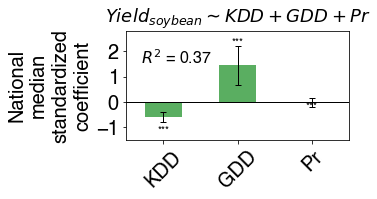

In [28]:
width=.5
cmap = plt.cm.get_cmap('PRGn')

plt.figure(figsize=(4,2))
plt.xlim([.5,3.5])
plt.ylim([-1.5,2.8])

xvalues = [1,2,3]
yvalues = [np.nanmedian(mdl_KDD_GDD_SoybeanYield_Norm_Coefs['KDD_DetrendNorm'][adjNn]), 
           np.nanmedian(mdl_KDD_GDD_SoybeanYield_Norm_Coefs['GDD_DetrendNorm'][adjNn]),
           np.nanmedian(mdl_KDD_GDD_SoybeanYield_Norm_Coefs['Pr_DetrendNorm'][adjNn])]
pvalues = [len(np.where(mdl_KDD_GDD_SoybeanYield_Norm_PValues['KDD_DetrendNorm'][adjNn]<0.05)[0])/len(adjNn), 
           len(np.where(mdl_KDD_GDD_SoybeanYield_Norm_PValues['GDD_DetrendNorm'][adjNn]<0.05)[0])/len(adjNn),
           len(np.where(mdl_KDD_GDD_SoybeanYield_Norm_PValues['Pr_DetrendNorm'][adjNn]<0.05)[0])/len(adjNn)]
yerrs = [np.nanstd(mdl_KDD_GDD_SoybeanYield_Norm_Coefs['KDD_DetrendNorm'][adjNn]), 
         np.nanstd(mdl_KDD_GDD_SoybeanYield_Norm_Coefs['GDD_DetrendNorm'][adjNn]),
         np.nanstd(mdl_KDD_GDD_SoybeanYield_Norm_Coefs['Pr_DetrendNorm'][adjNn])]
facecolors = [cmap(.8), cmap(.8), '#aaaaaa']
b = plt.bar(xvalues, yvalues, width=width, yerr=yerrs, capsize=3, error_kw={'lw':1})
plt.plot([.5, 3.5], [0,0], '-k', lw=1)
plt.xticks([1,2,3], rotation=45, fontsize=20)
plt.yticks([-1, 0, 1, 2], fontsize=20)
plt.gca().set_xticklabels(['KDD', 'GDD', 'Pr'], fontsize=20)
plt.ylabel('National\nmedian\nstandardized\ncoefficient', fontsize=20)

plt.title('$Yield_{soybean} \sim KDD + GDD + Pr$', fontsize=18)

plt.text(.7, 1.5, '$R^2$ = %0.2f'%(np.nanmedian(mdl_KDD_GDD_SoybeanYield_Coefs['R2'][adjNn])), fontdict = {'size':16, 'family':'Helvetica'})

errBarLC = b.errorbar.lines[2][0]
for pat, errline, yval, pval, c in zip(b.patches, errBarLC.get_segments(), yvalues, pvalues, facecolors):
    pat.set_facecolor(c)
    
    xpos = errline[0][0]
    if yval >= 0:
        ypos = errline[1][1]
    else:
        ypos = errline[0][1]*1.55
    
    if pval > .8:
        plt.text(xpos, ypos, '***', ha='center')
#     elif pval < .05:
#         plt.text(xpos, ypos, '**', ha='center')
#     elif pval < .1:
#         plt.text(xpos, ypos, '*', ha='center')

plt.savefig('reg-coef-soybean-yield-kdd-gdd-pr-nass-%s.eps'%wxData, format='eps', dpi=500, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
np.matlib.repmat(np.nanmean(countyMaizeYield[nnAgInt], axis=1), 91, 1).T

In [49]:
maizeYieldChgAgInt = (maizeYieldChgFeedbackWithAgInt[nnAgInt, :]*NYears/10) / \
                        np.matlib.repmat(np.nanmean(countyMaizeYield[nnAgInt], axis=1), maizeYieldChgFeedbackWithAgInt.shape[1], 1).T*100
maizeYieldChgNoAgInt = (maizeYieldChgFeedbackWithoutAgInt[nnNoAgInt, :]*NYears/10) / \
                        np.matlib.repmat(np.nanmean(countyMaizeYield[nnNoAgInt], axis=1), maizeYieldChgFeedbackWithoutAgInt.shape[1], 1).T*100

maizeYieldChgAgInt = np.reshape(maizeYieldChgAgInt, [maizeYieldChgAgInt.size, 1])
maizeYieldChgNoAgInt = np.reshape(maizeYieldChgNoAgInt, [maizeYieldChgNoAgInt.size, 1])

NameError: name 'nnAgInt' is not defined

In [42]:
len(nnNonIr)/len(adjNn)

0.862796833773087

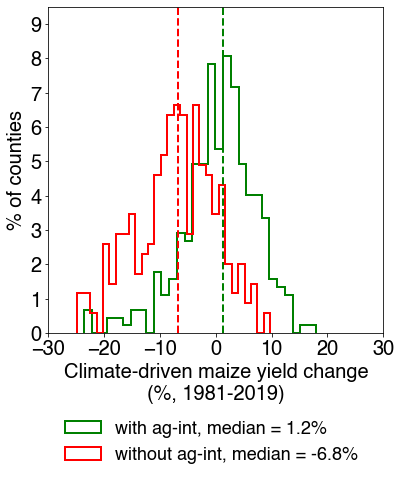

In [53]:
from scipy.stats import norm

cur_nn = adjNn#nnNonIr

# convert these trends back to changes over the time period
nnAgInt = cur_nn[np.where(~np.isnan((maizeYieldChgFeedbackWithAgInt[cur_nn,0,0]*NYears/10)/np.nanmean(countyMaizeYield[cur_nn], axis=1)*100))[0]]
nnNoAgInt = cur_nn[np.where(~np.isnan((maizeYieldChgFeedbackWithoutAgInt[cur_nn,0,0]*NYears/10)/np.nanmean(countyMaizeYield[cur_nn], axis=1)*100))[0]]

maizeYieldChgAgInt = (np.nanmean(np.nanmean(maizeYieldChgFeedbackWithAgInt[nnAgInt, :, :], axis=2), axis=1)*NYears/10)/np.nanmean(countyMaizeYield[nnAgInt], axis=1)*100
maizeYieldChgNoAgInt = (np.nanmean(np.nanmean(maizeYieldChgFeedbackWithoutAgInt[nnNoAgInt, :, :], axis=2), axis=1)*NYears/10)/np.nanmean(countyMaizeYield[nnNoAgInt], axis=1)*100

maizeYieldChgAgInt = maizeYieldChgAgInt[abs(maizeYieldChgAgInt)<25]
maizeYieldChgNoAgInt = maizeYieldChgNoAgInt[abs(maizeYieldChgNoAgInt)<25]

plt.figure(figsize=(6,6))

plt.xlim([-25, 25])
if wxData == 'era5':
    plt.ylim([0, 0.095])
elif wxData == 'gldas':
    plt.ylim([0, 0.1])

histAgIntN, histAgIntBins, histAgIntPatches = plt.hist(maizeYieldChgAgInt, bins=30, density=True, histtype='step', color='g', lw=2, \
                                                       label='with ag-int, median = %0.1f%%'%np.nanmedian(maizeYieldChgAgInt))

histNoAgIntN, histNoAgIntBins, histNoAgIntPatches = plt.hist(maizeYieldChgNoAgInt, bins=30, density=True, histtype='step', color='r', lw=2, \
                                                             label='without ag-int, median = %0.1f%%'%np.nanmedian(maizeYieldChgNoAgInt))
if wxData == 'era5':
#     plt.plot([0,0], [0,0.09], '-k', lw=2)
    plt.plot([np.nanmedian(maizeYieldChgAgInt),np.nanmedian(maizeYieldChgAgInt)], [0,0.095], '--g', lw=2)
    plt.plot([np.nanmedian(maizeYieldChgNoAgInt),np.nanmedian(maizeYieldChgNoAgInt)], [0,0.095], '--r', lw=2)
elif wxData == 'gldas':
    plt.plot([0,0], [0,0.1], '-k', lw=2)
    plt.plot([np.nanmedian(maizeYieldChgAgInt),np.nanmedian(maizeYieldChgAgInt)], [0,0.1], '--g', lw=2)
    plt.plot([np.nanmedian(maizeYieldChgNoAgInt),np.nanmedian(maizeYieldChgNoAgInt)], [0,0.1], '--r', lw=2)
    
plt.xlabel('Climate-driven maize yield change\n(%, 1981-2019)', fontsize=20)
plt.ylabel('% of counties', fontsize=20)

if wxData == 'era5':
    plt.yticks([0, .01, .02, .03, .04, .05, .06, .07, .08, .09], fontsize=20)
    plt.gca().set_yticklabels([0,1,2,3,4,5,6,7, 8, 9], fontsize=20)
elif wxData == 'gldas':
    plt.yticks([0, .01, .02, .03, .04, .05, .06, .07, .08, .09, .1], fontsize=20)
    plt.gca().set_yticklabels([0,1,2,3,4,5,6,7,8,9,10], fontsize=20)
    
plt.xticks([-30, -20, -10, 0, 10, 20, 30], fontsize=20)

leg = plt.legend(prop = {'size':18, 'family':'Helvetica'}, loc = 'lower left', bbox_to_anchor=(0, -.45))
leg.get_frame().set_linewidth(0.0)

if useDeepak:
    plt.savefig('maize-yield-chg-with-and-without-feedback-deepak-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.01)
else:
    plt.savefig('maize-yield-chg-with-and-without-feedback-nass-%s-unc-%d-%d.png'%(wxData, n_samples, n_bootstraps), format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

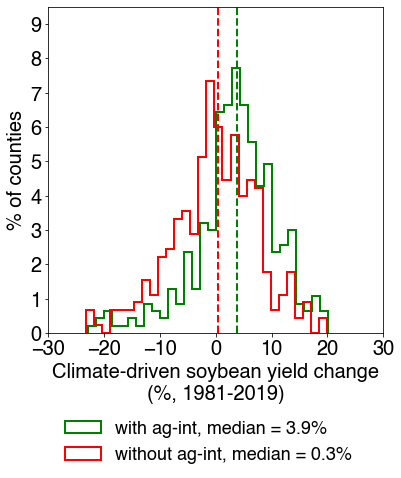

In [55]:
from scipy.stats import norm

cur_nn = adjNn#nnNonIr

# convert these trends back to changes over the time period
nnAgInt = cur_nn[np.where(~np.isnan((soybeanYieldChgFeedbackWithAgInt[cur_nn, 0, 0]*NYears/10)/np.nanmean(countySoybeanYield[cur_nn], axis=1)*100))[0]]
nnNoAgInt = cur_nn[np.where(~np.isnan((soybeanYieldChgFeedbackWithoutAgInt[cur_nn, 0, 0]*NYears/10)/np.nanmean(countySoybeanYield[cur_nn], axis=1)*100))[0]]

soybeanYieldChgAgInt = (np.nanmean(np.nanmean(soybeanYieldChgFeedbackWithAgInt[nnAgInt, :, :], axis=2), axis=1)*NYears/10)/np.nanmean(countySoybeanYield[nnAgInt], axis=1)*100
soybeanYieldChgNoAgInt = (np.nanmean(np.nanmean(soybeanYieldChgFeedbackWithoutAgInt[nnNoAgInt, :, :], axis=2), axis=1)*NYears/10)/np.nanmean(countySoybeanYield[nnNoAgInt], axis=1)*100

soybeanYieldChgAgInt = soybeanYieldChgAgInt[abs(soybeanYieldChgAgInt)<25]
soybeanYieldChgNoAgInt = soybeanYieldChgNoAgInt[abs(soybeanYieldChgNoAgInt)<25]

plt.figure(figsize=(6,6))

plt.xlim([-25, 25])
if wxData == 'era5':
    plt.ylim([0, 0.095])
elif wxData == 'gldas':
    plt.ylim([0, 0.095])

histAgIntN, histAgIntBins, histAgIntPatches = plt.hist(soybeanYieldChgAgInt, bins=30, density=True, histtype='step', color='g', lw=2, \
                                                       label='with ag-int, median = %0.1f%%'%np.nanmedian(soybeanYieldChgAgInt))

histNoAgIntN, histNoAgIntBins, histNoAgIntPatches = plt.hist(soybeanYieldChgNoAgInt, bins=30, density=True, histtype='step', color='r', lw=2, \
                                                             label='without ag-int, median = %0.1f%%'%np.nanmedian(soybeanYieldChgNoAgInt))

if wxData == 'era5':
#     plt.plot([0,0], [0,0.09], '-k', lw=2)
    plt.plot([np.nanmedian(soybeanYieldChgAgInt),np.nanmedian(soybeanYieldChgAgInt)], [0,0.095], '--g', lw=2)
    plt.plot([np.nanmedian(soybeanYieldChgNoAgInt),np.nanmedian(soybeanYieldChgNoAgInt)], [0,0.095], '--r', lw=2)
elif wxData == 'gldas':
    plt.plot([0,0], [0,0.1], '-k', lw=2)
    plt.plot([np.nanmedian(soybeanYieldChgAgInt),np.nanmedian(soybeanYieldChgAgInt)], [0,0.1], '--g', lw=2)
    plt.plot([np.nanmedian(soybeanYieldChgNoAgInt),np.nanmedian(soybeanYieldChgNoAgInt)], [0,0.1], '--r', lw=2)
\
plt.xlabel('Climate-driven soybean yield change\n(%, 1981-2019)', fontsize=20)
plt.ylabel('% of counties', fontsize=20)
if wxData == 'era5':
    plt.yticks([0, .01, .02, .03, .04, .05, .06, .07, .08, .09], fontsize=20)
    plt.gca().set_yticklabels([0,1,2,3,4,5,6,7, 8, 9], fontsize=20)
elif wxData == 'gldas':
    plt.yticks([0, .01, .02, .03, .04, .05, .06, .07, .08, .09, .1], fontsize=20)
    plt.gca().set_yticklabels([0,1,2,3,4,5,6,7,8,9,10], fontsize=20)
    
plt.xticks([-30, -20, -10, 0, 10, 20, 30], fontsize=20)

leg = plt.legend(prop = {'size':18, 'family':'Helvetica'}, loc = 'lower left', bbox_to_anchor=(0, -.45))
leg.get_frame().set_linewidth(0.0)

if useDeepak:
    plt.savefig('soybean-yield-chg-with-and-without-feedback-deepak-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.01)
else:
    plt.savefig('soybean-yield-chg-with-and-without-feedback-nass-%s-unc-%d-%d.png'%(wxData, n_samples, n_bootstraps), format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
scipy.stats.ttest_1samp(soybeanYieldChgNoAgInt, 0)

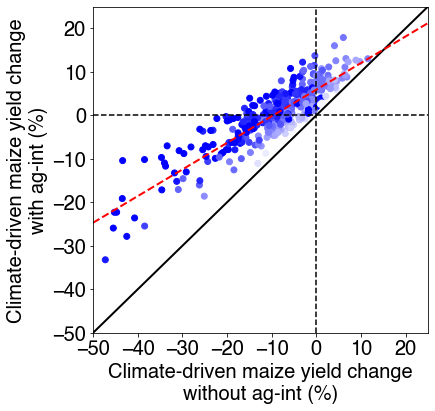

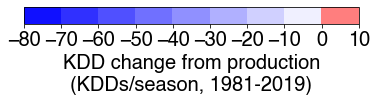

In [56]:
nnAgInt = adjNn[np.where(~np.isnan((maizeYieldChgFeedbackWithAgInt[adjNn, 0, 0]*NYears/10)/np.nanmean(countyMaizeYield[adjNn], axis=1)*100))[0]]
nnNoAgInt = adjNn[np.where(~np.isnan((maizeYieldChgFeedbackWithoutAgInt[adjNn, 0, 0]*NYears/10)/np.nanmean(countyMaizeYield[adjNn], axis=1)*100))[0]]

maizeYieldChgAgInt = (np.nanmean(np.nanmean(maizeYieldChgFeedbackWithAgInt[nnAgInt, :, :], axis=2), axis=1)*NYears/10)/np.nanmean(countyMaizeYield[nnAgInt], axis=1)*100
maizeYieldChgNoAgInt = (np.nanmean(np.nanmean(maizeYieldChgFeedbackWithoutAgInt[nnNoAgInt, :, :], axis=2), axis=1)*NYears/10)/np.nanmean(countyMaizeYield[nnNoAgInt], axis=1)*100

X = sm.add_constant(maizeYieldChgNoAgInt)
mdl = sm.OLS(maizeYieldChgAgInt, X).fit()

x1 = -50
x2 = 25

kddChg = (np.nanmean(np.nanmean(kddChgFeedbackWithAgInt[nnAgInt, :, :], axis=2), axis=1)*NYears/10)-(np.nanmean(np.nanmean(kddChgFeedbackWithoutAgInt[nnNoAgInt, :, :], axis=2), axis=1)*NYears/10)

midnorm = MidpointNormalize(vmin=-80, vcenter=0, vmax=10)

fig = plt.figure(figsize=(6,6))
plt.xlim([-50, 25])
plt.ylim([-50, 25])
a = plt.scatter(maizeYieldChgNoAgInt, maizeYieldChgAgInt, c=kddChg, cmap='bwr', norm=midnorm)
plt.plot([-50, 25], [0, 0], '--k', lw=1.5)
plt.plot([0, 0], [-50, 25], '--k', lw=1.5)
plt.plot([-50, 25], [-50, 25], '-k', lw=2)

plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--r', lw=2)

plt.ylabel('Climate-driven maize yield change\nwith ag-int (%)', fontsize=20)
plt.xlabel('Climate-driven maize yield change\nwithout ag-int (%)', fontsize=20)
plt.yticks([-50, -40, -30, -20, -10, 0, 10, 20], fontsize=20)
plt.xticks([-50, -40, -30, -20, -10, 0, 10, 20], fontsize=20)

if useDeepak:
    plt.savefig('maize-yield-chg-with-and-without-feedback-scatter-deepak-%s-%d-%d.png'%(wxData, n_samples, n_bootstraps), format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)
else:
    plt.savefig('maize-yield-chg-with-and-without-feedback-scatter-nass-%s-%d-%d.png'%(wxData, n_samples, n_bootstraps), format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

fig = plt.figure()
plt.gca().set_visible(False)

cbar = fig.colorbar(a, ax=plt.gca(), orientation='horizontal', 
                    ticks=np.arange(-80, 11, 10), boundaries=np.arange(-80, 11, 10))
cbar.set_label('KDD change from production\n(KDDs/season, 1981-2019)', fontsize=20)
cbar.ax.tick_params(labelsize=20)

if useDeepak:
    plt.savefig('maize-yield-chg-with-and-without-feedback-scatter-colorbar-deepak-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)
else:
    plt.savefig('maize-yield-chg-with-and-without-feedback-scatter-colorbar-nass-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)


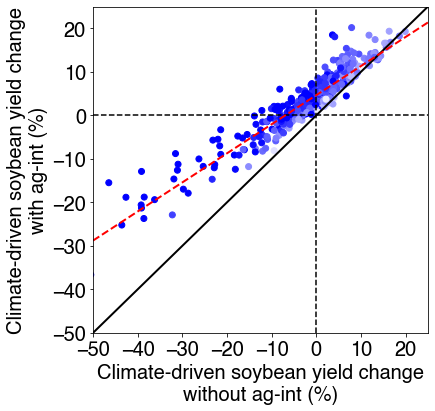

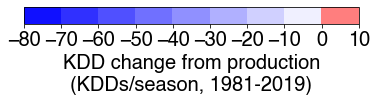

In [57]:

nnAgInt = adjNn[np.where(~np.isnan((soybeanYieldChgFeedbackWithAgInt[adjNn, 0, 0]*NYears/10)/np.nanmean(countySoybeanYield[adjNn], axis=1)*100))[0]]
nnNoAgInt = adjNn[np.where(~np.isnan((soybeanYieldChgFeedbackWithoutAgInt[adjNn, 0, 0]*NYears/10)/np.nanmean(countySoybeanYield[adjNn], axis=1)*100))[0]]


soybeanYieldChgAgInt = (np.nanmean(np.nanmean(soybeanYieldChgFeedbackWithAgInt[nnAgInt, :, :], axis=2), axis=1)*NYears/10)/np.nanmean(countySoybeanYield[nnAgInt], axis=1)*100
soybeanYieldChgNoAgInt = (np.nanmean(np.nanmean(soybeanYieldChgFeedbackWithoutAgInt[nnNoAgInt, :, :], axis=2), axis=1)*NYears/10)/np.nanmean(countySoybeanYield[nnNoAgInt], axis=1)*100

X = sm.add_constant(soybeanYieldChgNoAgInt)
mdl = sm.OLS(soybeanYieldChgAgInt, X).fit()

x1 = -50
x2 = 25

kddChg = (np.nanmean(np.nanmean(kddChgFeedbackWithAgInt[nnAgInt, :, :], axis=2), axis=1)*NYears/10)-(np.nanmean(np.nanmean(kddChgFeedbackWithoutAgInt[nnNoAgInt, :, :], axis=2), axis=1)*NYears/10)

midnorm = MidpointNormalize(vmin=-80, vcenter=0, vmax=10)

fig = plt.figure(figsize=(6,6))
plt.xlim([-50, 25])
plt.ylim([-50, 25])
a = plt.scatter(soybeanYieldChgNoAgInt, soybeanYieldChgAgInt, c=kddChg, cmap='bwr', norm=midnorm)
plt.plot([-50, 25], [0, 0], '--k', lw=1.5)
plt.plot([0, 0], [-50, 25], '--k', lw=1.5)
plt.plot([-50, 25], [-50, 25], '-k', lw=2)

plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--r', lw=2)

plt.ylabel('Climate-driven soybean yield change\nwith ag-int (%)', fontsize=20)
plt.xlabel('Climate-driven soybean yield change\nwithout ag-int (%)', fontsize=20)
plt.yticks([-50, -40, -30, -20, -10, 0, 10, 20], fontsize=20)
plt.xticks([-50, -40, -30, -20, -10, 0, 10, 20], fontsize=20)

if useDeepak:
    plt.savefig('soybean-yield-chg-with-and-without-feedback-scatter-deepak-%s-%d-%d.png'%(wxData, n_samples, n_bootstraps), format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)
else:
    plt.savefig('soybean-yield-chg-with-and-without-feedback-scatter-nass-%s-%d-%d.png'%(wxData, n_samples, n_bootstraps), format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

fig = plt.figure()
plt.gca().set_visible(False)

cbar = fig.colorbar(a, ax=plt.gca(), orientation='horizontal', 
                    ticks=np.arange(-80, 11, 10), boundaries=np.arange(-80, 11, 10))
cbar.set_label('KDD change from production\n(KDDs/season, 1981-2019)', fontsize=20)
cbar.ax.tick_params(labelsize=20)

if useDeepak:
    plt.savefig('soybean-yield-chg-with-and-without-feedback-scatter-colorbar-deepak-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)
else:
    plt.savefig('soybean-yield-chg-with-and-without-feedback-scatter-colorbar-nass-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)


In [59]:
print('maize quad TL: %.2f'%(len(np.where((maizeYieldChgNoAgInt<0) & (maizeYieldChgAgInt>0))[0])/len(maizeYieldChgNoAgInt)))
print('soybean quad TL: %.2f'%(len(np.where((soybeanYieldChgNoAgInt<0) & (soybeanYieldChgAgInt>0))[0])/len(soybeanYieldChgNoAgInt)))

print('maize quad BL: %.2f'%(len(np.where((maizeYieldChgNoAgInt<0) & (maizeYieldChgAgInt<0))[0])/len(maizeYieldChgNoAgInt)))
print('soybean quad BL: %.2f'%(len(np.where((soybeanYieldChgNoAgInt<0) & (soybeanYieldChgAgInt<0))[0])/len(soybeanYieldChgNoAgInt)))

print('maize quad TR: %.2f'%(len(np.where((maizeYieldChgNoAgInt>0) & (maizeYieldChgAgInt>0))[0])/len(maizeYieldChgNoAgInt)))
print('soybean quad TR: %.2f'%(len(np.where((soybeanYieldChgNoAgInt>0) & (soybeanYieldChgAgInt>0))[0])/len(soybeanYieldChgNoAgInt)))

maize quad TL: 0.41
soybean quad TL: 0.29
maize quad BL: 0.44
soybean quad BL: 0.25
maize quad TR: 0.15
soybean quad TR: 0.46


In [ ]:
nnAgInt = adjNn[np.where(~np.isnan((maizeYieldChgFeedbackWithAgInt[adjNn]*NYears/10)/np.nanmean(countyMaizeYield[adjNn], axis=1)*100))[0]]
nnNoAgInt = adjNn[np.where(~np.isnan((maizeYieldChgFeedbackWithoutAgInt[adjNn]*NYears/10)/np.nanmean(countyMaizeYield[adjNn], axis=1)*100))[0]]

netRadChg = np.nanmean((netRadObsTrend[nnAgInt]*NYears/10)/np.nanmean(countyNetRad[nnAgInt, :], axis=1)*100)
netRadErr = np.nanstd((netRadObsTrend[nnAgInt]*NYears/10)/np.nanmean(countyNetRad[nnAgInt, :], axis=1)*100)

lhChg = [np.nanmean(lhChgFeedbackWithoutAgInt[nnAgInt]*NYears/10/np.nanmean(countySlhf[nnAgInt,:], axis=1))*100, \
         np.nanmean(lhChgFeedbackWithAgInt[nnAgInt]*NYears/10/np.nanmean(countySlhf[nnAgInt,:], axis=1))*100]
lhErr = [np.nanstd(lhChgFeedbackWithoutAgInt[nnAgInt]*NYears/10/np.nanmean(countySlhf[nnAgInt,:], axis=1)*100), \
         np.nanstd(lhChgFeedbackWithAgInt[nnAgInt]*NYears/10/np.nanmean(countySlhf[nnAgInt,:], axis=1)*100)]

lhObsChg = [np.nanmean((lhObsTrend[nnAgInt]*NYears/10)/np.nanmean(countySlhf[nnAgInt,:], axis=1)*100)]
lhObsErr = [np.nanstd((lhObsTrend[nnAgInt]*NYears/10)/np.nanmean(countySlhf[nnAgInt,:], axis=1)*100)]

shChg = [np.nanmean(shChgFeedbackWithoutAgInt[nnAgInt]*NYears/10/np.nanmean(countySshf[nnAgInt,:], axis=1))*100, \
         np.nanmean(shChgFeedbackWithAgInt[nnAgInt]*NYears/10/np.nanmean(countySshf[nnAgInt,:], axis=1))*100]
shErr = [np.nanstd(shChgFeedbackWithoutAgInt[nnAgInt]*NYears/10/np.nanmean(countySshf[nnAgInt,:], axis=1)*100), \
         np.nanstd(shChgFeedbackWithAgInt[nnAgInt]*NYears/10/np.nanmean(countySshf[nnAgInt,:], axis=1)*100)]


labels = ['Net\nRadiation', 'Latent\nHeat', 'Sensible\nHeat']

x = [1,2,3]
width = .35
plt.figure(figsize=(6,6))
plt.ylim([.5, 3.5])

plt.barh([1], netRadChg, height=width, xerr=netRadErr, capsize=3, error_kw={'lw':1}, facecolor='gray', label='Observed')
plt.plot(netRadChg, [1], 'ok', markersize=5)

plt.barh([2-width/2], lhChg[0], height=width, xerr=lhErr[0], capsize=3, error_kw={'lw':1}, facecolor='#e34627', label='No ag-int')
plt.plot(lhChg[0], [2-width/2], 'ok', markersize=5)
plt.barh([2+width/2], lhChg[1], height=width, xerr=lhErr[1], capsize=3, error_kw={'lw':1}, facecolor='#19a651', label='With ag-int')
plt.plot(lhChg[1], [2+width/2], 'ok', markersize=5)

plt.barh([3-width/2], shChg[0], height=width, xerr=shErr[0], capsize=3, error_kw={'lw':1}, facecolor='#e34627')
plt.plot(shChg[0], [3-width/2], 'ok', markersize=5)
plt.barh([3+width/2], shChg[1], height=width, xerr=shErr[1], capsize=3, error_kw={'lw':1}, facecolor='#19a651')
plt.plot(shChg[1], [3+width/2], 'ok', markersize=5)

plt.plot([0, 0], [.5, 3.5], '-k', lw=1)

plt.gca().set_yticks(x)
plt.gca().set_yticklabels(labels, fontsize=20)

plt.xlabel('U.S. mean change (%, 1981-2019)', fontsize=20)
plt.xticks(range(-20, 81, 10), fontsize=20)

plt.gca().invert_yaxis()  # labels read top-to-bottom

l1 = plt.legend(prop = {'size':16, 'family':'Helvetica'}, loc='upper right')
l1.get_frame().set_linewidth(0)


In [86]:
scipy.stats.ks_2samp(maizeYieldChgAgInt, maizeYieldChgNoAgInt)

Ks_2sampResult(statistic=0.48158640226628896, pvalue=1.9154715300362132e-37)

In [87]:
# calculate the fraction of yield trend explained by feedback over upper midwest to compare with Butler et al PNAS 
# (but only the 'climate' component, not changes to growing season length)

print('fraction of trend from ag-int in upper midwest')
inds = []
for si, s in enumerate(stateSel):
    if s in ['IA', 'MN', 'SD', 'NE', 'WI', 'IL', 'IN', 'MI', 'OH', 'KY', 'MO']:
        inds.append(si)
inds = np.array(inds)
print('maize: %.2f%%'%np.nanmean(np.nanmean(np.nanmean(maizeYieldTrendFrac[inds, :, :]))))

inds = []
for si, s in enumerate(stateSel):
    if s in ['IA', 'MN', 'SD', 'NE', 'WI', 'IL', 'IN', 'MI', 'OH', 'KY', 'MO']:
        inds.append(si)
inds = np.array(inds)
print('soybean: %.2f%%'%np.nanmean(np.nanmean(np.nanmean(soybeanYieldTrendFrac[inds, :, :]))))

fraction of trend from ag-int in upper midwest


NameError: name 'stateSel' is not defined